In [3]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt


In [4]:
dataset=torchvision.datasets.CIFAR10(root='/data',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_data=torchvision.datasets.CIFAR10(root='/data',train=False,transform=torchvision.transforms.ToTensor(),download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(len(dataset),len(test_data))
image,label=dataset[0]
image.shape

50000 10000


torch.Size([3, 32, 32])

In [11]:
classes=dataset.classes
dataset[0][0].shape

torch.Size([3, 32, 32])

In [7]:
#to plot image
def show_image(image,label):
  print('Label: ',classes[label])
  plt.imshow(image.permute(1,2,0)) #permute to move the no. of channels to last


Label:  truck


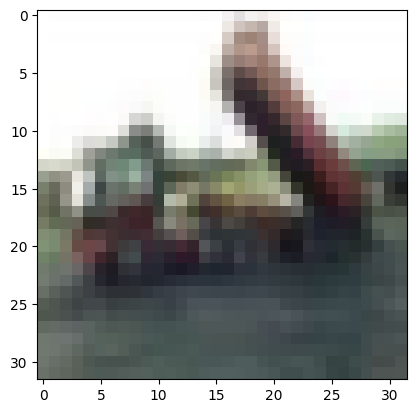

In [16]:
image,label=dataset[0]
show_image(*dataset[2])

In [17]:
#creating a validation set
from torch.utils.data import random_split
#to ensure we always create same validation set , we'll set a seed for the random number generator
random_seed = 42
torch.manual_seed(random_seed)

In [18]:
val_size = 5000
train_size = len(dataset) - val_size
train_ds , val_ds = random_split(dataset,[train_size,val_size])
len(train_ds)

45000

In [19]:
#making batches of the images
from torch.utils.data import DataLoader
batch_size = 128
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=batch_size*2)

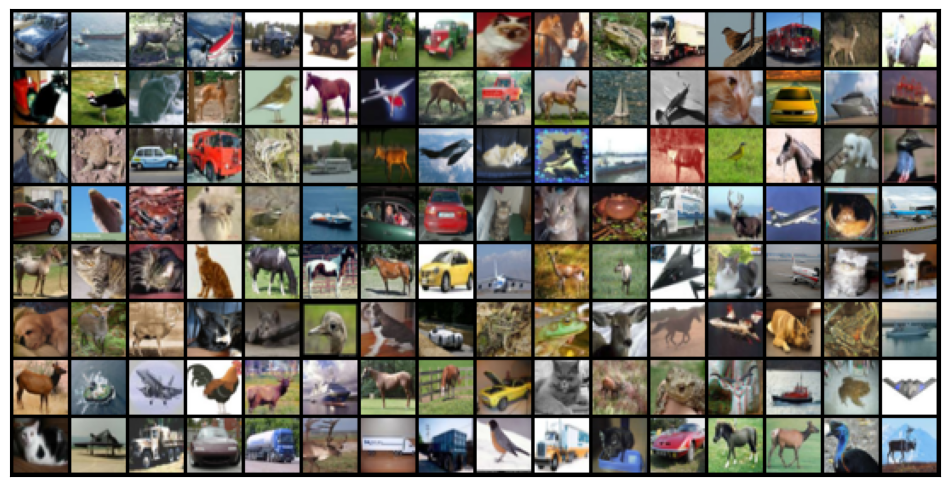

In [25]:
#just looking at the batch of image
from torchvision.utils import make_grid
for images,label in train_dl:
  fig, axis = plt.subplots(figsize=(12,8))
  axis.set_xticks([])
  axis.set_yticks([])
  axis.imshow(make_grid(images, nrow=16).permute(1,2,0))
  break

In [31]:
import torch.nn as nn
import torch.nn.functional as F

In [33]:
class ImageClassificationBase(nn.Module): #inheriting from the nn module
  def training_step(self,batch):
    images,labels = batch                 #from the batch seperating the inputs and outputs
    out = self(images)                    #generating the predictions
    loss=F.cross_entropy(out, labels)     #Calculate the loss
    return loss

  def validation_step(self,batch):
    images, labels = batch
    out = self(images)                       #generate the predictions
    loss = F.cross_entropy(out, labels)     #calculate the loss
    acc = accuracy(out, labels)             #calculate the accuracy
    return {'val_loss' : loss.detach(), "val_acc" : acc}

  def validation_epoch_end(self,results):
    batch_losses = [x['val_loss'] for x in results]
    epoch_loss = torch.stack(batch_losses).mean()    # stack-concatenate a sequence of tensors
    batch_accs = [x['val_acc'] for x in results]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

def accuracy(output, labels):
  _, preds = torch.max(output,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))


In [34]:
#Creating the class for the model
class Cifar10CNN(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential( #instead of normal self.fn things
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output= 64 X 16 X 16

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output= 128 X 8 X 8

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output= 256 X 4 X 4

        # nn.Conv2d(in_channels=256, out_channels=512, kernel_size= 3, stride=1, padding=1),
        # nn.ReLU(),
        # nn.Conv2d(512, 512, kernel_size= 3, stride=1, padding=1),
        # nn.ReLU(),
        # nn.MaxPool2d(2,2), #output= 512 X 2 X 2

        nn.Flatten(),
        nn.Linear(256*4*4,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )
  def forward(self,batch):
      return self.network(batch)
model=Cifar10CNN()

In [35]:
for image,label in train_dl:
  print('image.shape: ',image.shape)
  out=model(image)
  print(out.shape)
  break


image.shape:  torch.Size([128, 3, 32, 32])
torch.Size([128, 10])


In [36]:

@torch.no_grad()
def evaluate(model,val_dl):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_dl]  #cal the pred and acc for each batch
  return model.validation_epoch_end(outputs)                  #cal the avg loss and acc

def fit(epochs, lr,  model, train_dl, val_dl, opt_func):
    history=[]
    optimizer = opt_func(model.parameters(),lr)

    for epoch in range(epochs):
      #Training Stage
      model.train()
      train_losses=[]     #storing all the training losses to print
      for batch in train_dl:
        # print(1)
        loss=model.training_step(batch)
        train_losses.append(loss)
        # print(2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # print('running')

      #validation stage
      result = evaluate(model, val_dl)  #cal the loss and acc for each batch of val_dl
      result['train_loss']=torch.stack(train_losses).mean().item()
      model.epoch_end(epoch,result)
      history.append(result)
    return history


In [26]:
evaluate(model, val_dl)

{'val_loss': 2.2980265617370605, 'val_acc': 0.11711857467889786}

In [ ]:
lr=0.001
opt_func=torch.optim.Adam
epochs=10

history=fit(epochs,lr,model,train_dl,val_dl,opt_func)

In [40]:
def plot_accuracies(history):
  accuracies=[1,2,3]
  plt.plot(accuracies,'x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title("Accuracy vs no. of epochs")


In [ ]:
torch.save(model.state_dict(),'cifar10_model.pth')